We first need to format and clean the data. Here we get simplfiy the files by separating them out into files and dropping all missing speeds.

In [4]:
import pandas as pd
import os

def clean_wind_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    station_name = lines[0].replace('Station Name:', '').strip()
    header_line = 0

    for i, line in enumerate(lines):
        if line.startswith('year,month,meant'):
            header_line = i
            break
    header = lines[header_line].strip().split(',')
    data_rows = []
    for line in lines[header_line+1:]:
        if line.strip():
            data_rows.append(line.strip().split(','))

    df = pd.DataFrame(data_rows, columns=header)
    df['station'] = station_name
    df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce')
    # Convert from knots to m/s (1 knot = 0.514444 m/s)
    df['wdsp_ms'] = df['wdsp'] * 0.514444
    df = df[['station', 'year', 'month', 'wdsp', 'wdsp_ms']]
    df = df.dropna(subset=['wdsp'])

    return df, station_name

def process_files_separately(file_list):
    os.makedirs('data/wind_clean', exist_ok=True)

    all_dfs = {}
    for file in file_list:
        try:
            print(f"Processing {file}...")
            df, station_name = clean_wind_data(file)
            clean_name = station_name.lower().replace(' ', '_')
            output_file = f"data/wind_clean/{clean_name}_wind_data.csv"
            df.to_csv(output_file, index=False)
            print(f"  Saved {len(df)} rows to {output_file}")
            all_dfs[station_name] = df

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

    return all_dfs

files = [
    'data/wind_raw/ballyhaise_cavan_monthly.csv',
    'data/wind_raw/dunsany_meath_monthly.csv',
    'data/wind_raw/knock_airport_mayo_monthly.csv',
    'data/wind_raw/oak_park_carlow_monthly.csv',
    'data/wind_raw/shannon_airport_clare_monthly.csv',
]

all_station_data = process_files_separately(files)
if all_station_data:
    for station_name, df in all_station_data.items():
        knots_stats = df['wdsp'].describe()
        ms_stats = df['wdsp_ms'].describe()
        print(f"\n{station_name}:")
        print("Wind Speed (knots):")
        print(knots_stats)
        print("\nWind Speed (m/s):")
        print(ms_stats)

Processing data/wind_raw/ballyhaise_cavan_monthly.csv...
  Saved 244 rows to data/wind_clean/ballyhaise_wind_data.csv
Processing data/wind_raw/dunsany_meath_monthly.csv...
  Saved 226 rows to data/wind_clean/dunsany_wind_data.csv
Processing data/wind_raw/knock_airport_mayo_monthly.csv...
  Saved 341 rows to data/wind_clean/knock_airport_wind_data.csv
Processing data/wind_raw/oak_park_carlow_monthly.csv...
  Saved 249 rows to data/wind_clean/oak_park_wind_data.csv
Processing data/wind_raw/shannon_airport_clare_monthly.csv...
  Saved 955 rows to data/wind_clean/shannon_airport_wind_data.csv

BALLYHAISE:
Wind Speed (knots):
count    244.000000
mean       6.404098
std        1.271136
min        3.300000
25%        5.500000
50%        6.200000
75%        7.200000
max       10.400000
Name: wdsp, dtype: float64

Wind Speed (m/s):
count    244.000000
mean       3.294550
std        0.653928
min        1.697665
25%        2.829442
50%        3.189553
75%        3.703997
max        5.350218
Name:

Next, I'm going to individually model all the wind stations using the weibull distribution to estimate the annual energy output


Ballyhaise:
  Shape parameter (k): 5.8375
  Scale parameter (A): 3.5567
  Mean wind speed: 3.29 m/s
  Wind power density: 24.44 W/m²
  Probability of wind speed > 3 m/s: 69.06%
  Data points: 244

Dunsany:
  Shape parameter (k): 6.1548
  Scale parameter (A): 4.3945
  Mean wind speed: 4.08 m/s
  Wind power density: 46.05 W/m²
  Probability of wind speed > 3 m/s: 90.90%
  Data points: 226

Knock Airport:
  Shape parameter (k): 7.4070
  Scale parameter (A): 5.1830
  Mean wind speed: 4.86 m/s
  Wind power density: 75.65 W/m²
  Probability of wind speed > 3 m/s: 98.27%
  Data points: 341

Oak Park:
  Shape parameter (k): 6.0259
  Scale parameter (A): 4.1003
  Mean wind speed: 3.80 m/s
  Wind power density: 37.42 W/m²
  Probability of wind speed > 3 m/s: 85.88%
  Data points: 249

Shannon Airport:
  Shape parameter (k): 5.8016
  Scale parameter (A): 5.3399
  Mean wind speed: 4.94 m/s
  Wind power density: 82.71 W/m²
  Probability of wind speed > 3 m/s: 96.54%
  Data points: 955


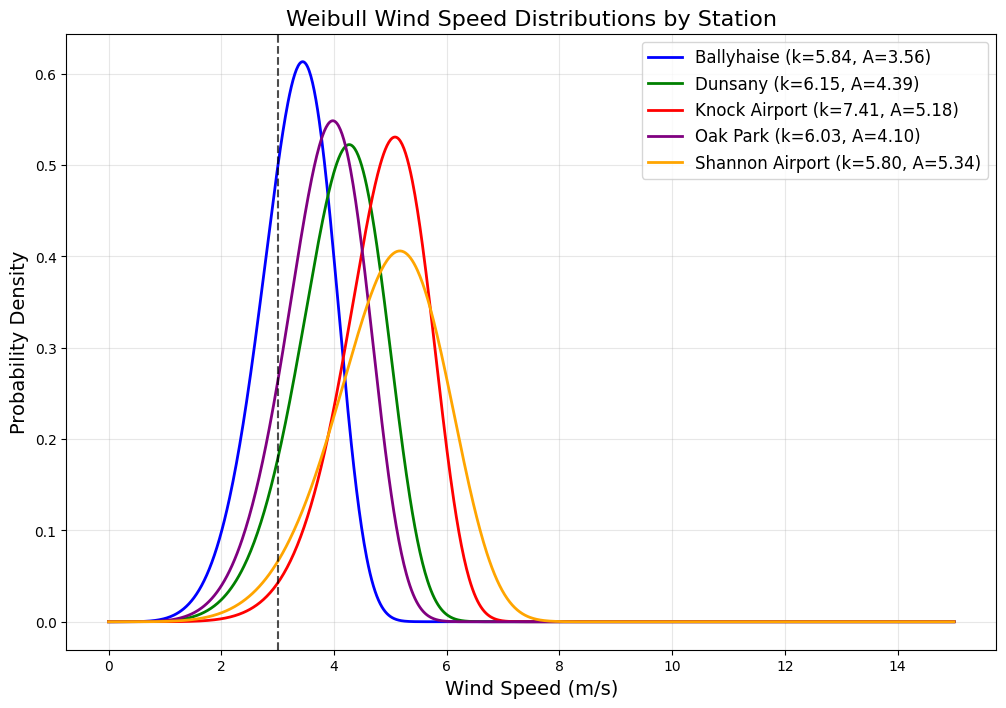

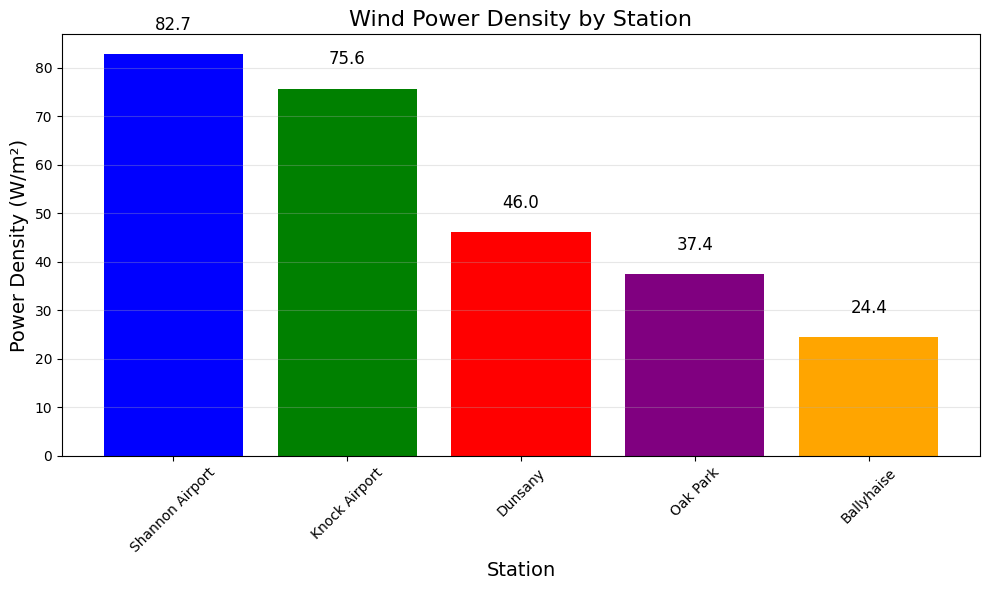


Stations Ranked by Wind Energy Potential:
1. Shannon Airport: 82.71 W/m²
2. Knock Airport: 75.65 W/m²
3. Dunsany: 46.05 W/m²
4. Oak Park: 37.42 W/m²
5. Ballyhaise: 24.44 W/m²

Results saved to 'results/weibull_analysis_results.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import os

# Function to fit Weibull distribution parameters using method of moments
def fit_weibull(wind_speeds):
    wind_speeds = wind_speeds[wind_speeds > 0]
    mean = np.mean(wind_speeds)
    variance = np.var(wind_speeds)
    cv = np.sqrt(variance) / mean
    k_approx = (0.9874 / cv) ** 1.0983
    A = mean / gamma(1 + 1/k_approx)

    return k_approx, A

# Function to calculate Weibull PDF
def weibull_pdf(x, k, A):
    return (k/A) * (x/A)**(k-1) * np.exp(-(x/A)**k)

# Function to calculate wind power density
def wind_power_density(k, A):
    air_density = 1.225
    return 0.5 * air_density * (A**3) * gamma(1 + 3/k)

def exceedance_probability(threshold, k, A):
    return np.exp(-(threshold/A)**k) * 100
stations = ['ballyhaise', 'dunsany', 'knock_airport', 'oak_park', 'shannon_airport']
colors = ['blue', 'green', 'red', 'purple', 'orange']

results = {}
for station in stations:
    try:
        file_path = f'data/wind_clean/{station}_wind_data.csv'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        df = pd.read_csv(file_path)
        wind_speeds = pd.to_numeric(df['wdsp_ms'], errors='coerce')
        wind_speeds = wind_speeds.dropna()
        if len(wind_speeds) == 0:
            print(f"No valid wind data for {station}")
            continue
        k, A = fit_weibull(wind_speeds)
        power = wind_power_density(k, A)
        exceed_prob = exceedance_probability(3.0, k, A)
        results[station] = {
            'shape_k': k,
            'scale_A': A,
            'mean_speed': np.mean(wind_speeds),
            'power_density': power,
            'exceed_probability': exceed_prob,
            'data_count': len(wind_speeds)
        }

    except Exception as e:
        print(f"Error processing {station}: {str(e)}")
os.makedirs('results', exist_ok=True)
plt.figure(figsize=(12, 8))
x = np.linspace(0, 15, 1000)
for i, station in enumerate(results.keys()):
    k = results[station]['shape_k']
    A = results[station]['scale_A']
    y = weibull_pdf(x, k, A)

    plt.plot(x, y, color=colors[i], linewidth=2,
             label=f"{station.replace('_', ' ').title()} (k={k:.2f}, A={A:.2f})")

plt.title('Weibull Wind Speed Distributions by Station', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.axvline(x=3.0, color='black', linestyle='--', alpha=0.7,
            label='Typical cut-in speed (3 m/s)')

plt.savefig('results/wind_distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 6))
stations_names = [s.replace('_', ' ').title() for s in results.keys()]
power_values = [results[s]['power_density'] for s in results.keys()]
sorted_indices = np.argsort(power_values)[::-1]
stations_names = [stations_names[i] for i in sorted_indices]
power_values = [power_values[i] for i in sorted_indices]

plt.bar(stations_names, power_values, color=colors)
plt.title('Wind Power Density by Station', fontsize=16)
plt.xlabel('Station', fontsize=14)
plt.ylabel('Power Density (W/m²)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(power_values):
    plt.text(i, v + 5, f"{v:.1f}", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('results/wind_power_comparison.png', dpi=300)
plt.show()
ranked_stations = sorted(results.items(),
                         key=lambda x: x[1]['power_density'],
                         reverse=True)

print("\nStations Ranked by Wind Energy Potential:")
for i, (station, params) in enumerate(ranked_stations, 1):
    print(f"{i}. {station.replace('_', ' ').title()}: {params['power_density']:.2f} W/m²")
results_df = pd.DataFrame({
    'Station': [s.replace('_', ' ').title() for s in results.keys()],
    'Shape_k': [results[s]['shape_k'] for s in results.keys()],
    'Scale_A': [results[s]['scale_A'] for s in results.keys()],
    'Mean_Wind_Speed_ms': [results[s]['mean_speed'] for s in results.keys()],
    'Power_Density_Wm2': [results[s]['power_density'] for s in results.keys()],
    'Exceedance_Probability_%': [results[s]['exceed_probability'] for s in results.keys()],
    'Data_Count': [results[s]['data_count'] for s in results.keys()]
})
results_df = results_df.sort_values('Power_Density_Wm2', ascending=False)
results_df.to_csv('results/weibull_analysis_results.csv', index=False)
print("\nResults saved to 'results/weibull_analysis_results.csv'")

Ok now, I want to get the average direction of the wind over the course of the month - we'll need the hourly data to augment this.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def clean_hourly_wind_direction_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    station_name = lines[0].replace('Station Name:', '').strip()
    header_line = 0
    for i, line in enumerate(lines):
        if line.startswith('date,ind,rain'):
            header_line = i
            break
    df = pd.read_csv(filename, skiprows=header_line)
    df['station'] = station_name
    df['wddir'] = pd.to_numeric(df['wddir'], errors='coerce')
    df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce')
    df['wdsp_ms'] = df['wdsp'] * 0.514444
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M', errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df[['station', 'date', 'year', 'month', 'wdsp', 'wdsp_ms', 'wddir']]
    df = df.dropna(subset=['wddir'])

    return df, station_name

def average_wind_direction(directions):
    radians = np.deg2rad(directions)
    sin_mean = np.mean(np.sin(radians))
    cos_mean = np.mean(np.cos(radians))
    avg_dir_rad = np.arctan2(sin_mean, cos_mean)
    avg_dir_deg = np.rad2deg(avg_dir_rad)
    avg_dir_deg = (avg_dir_deg + 360) % 360

    return avg_dir_deg

def calculate_monthly_direction(df):
    monthly_data = df.groupby(['year', 'month'])
    monthly_dirs = []

    for (year, month), group in monthly_data:
        avg_dir = average_wind_direction(group['wddir'])
        monthly_dirs.append({
            'year': year,
            'month': month,
            'avg_wddir': avg_dir,
            'count': len(group)
        })
    monthly_df = pd.DataFrame(monthly_dirs)

    return monthly_df

# Helper function to convert degrees to cardinal directions
def get_direction_name(degrees):
    dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ix = round(degrees / (360 / len(dirs))) % len(dirs)
    return dirs[ix]

def process_wind_direction_files(file_list):
    """Process all files and calculate monthly wind directions"""
    os.makedirs('data/wind_direction', exist_ok=True)

    all_station_dirs = {}
    for file in file_list:
        try:
            print(f"Processing {file}...")
            df, station_name = clean_hourly_wind_direction_data(file)
            monthly_dirs = calculate_monthly_direction(df)
            monthly_dirs['station'] = station_name
            clean_name = station_name.lower().replace(' ', '_')
            output_file = f"data/wind_direction/{clean_name}_wind_direction.csv"
            monthly_dirs.to_csv(output_file, index=False)
            print(f"  Saved {len(monthly_dirs)} monthly averages to {output_file}")
            all_station_dirs[station_name] = monthly_dirs
            plt.figure(figsize=(10, 8))
            theta = np.deg2rad(df['wddir'])
            ax = plt.subplot(111, polar=True)
            ax.set_theta_direction(-1)
            ax.set_theta_zero_location('N')
            bins = np.linspace(0, 2*np.pi, 37)
            counts, _ = np.histogram(theta, bins=bins)
            counts = counts / counts.sum() * 100
            ax.bar(bins[:-1], counts, width=bins[1]-bins[0], alpha=0.8)
            plt.title(f'Wind Direction Distribution - {station_name}')
            plt.savefig(f"data/wind_direction/{clean_name}_direction_rose.png", dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

    return all_station_dirs

hourly_files = [
    'data/wind_raw/wind_hourly_direction/shannon_airport_clare_hourly.csv',
    'data/wind_raw/wind_hourly_direction/ballyhaise_cavan_hourly.csv',
    'data/wind_raw/wind_hourly_direction/dunsany_meath_hourly.csv',
    'data/wind_raw/wind_hourly_direction/oak_park_carlow_hourly.csv',
    'data/wind_raw/wind_hourly_direction/knock_airport_mayo_hourly.csv',


]

all_station_dirs = process_wind_direction_files(hourly_files)
if all_station_dirs:
    for station_name, df in all_station_dirs.items():
        print(f"\n{station_name} Average Wind Direction:")
        overall_avg = average_wind_direction(df['avg_wddir'])
        print(f"Overall average direction: {overall_avg:.1f}° ({get_direction_name(overall_avg)})")
        df['season'] = df['month'].apply(lambda m:
            'Winter' if m in [12, 1, 2] else
            'Spring' if m in [3, 4, 5] else
            'Summer' if m in [6, 7, 8] else 'Autumn')
        seasonal_avgs = df.groupby('season').apply(
            lambda x: average_wind_direction(x['avg_wddir']))

        print("\nSeasonal Average Directions:")
        for season, avg in seasonal_avgs.items():
            print(f"{season}: {avg:.1f}° ({get_direction_name(avg)})")



Processing data/wind_raw/wind_hourly_direction/shannon_airport_clare_hourly.csv...


/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:22: DtypeWarning: Columns (6,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_line)


  Saved 956 monthly averages to data/wind_direction/shannon_airport_wind_direction.csv
Processing data/wind_raw/wind_hourly_direction/ballyhaise_cavan_hourly.csv...


/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:22: DtypeWarning: Columns (2,4,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_line)


  Saved 259 monthly averages to data/wind_direction/ballyhaise_wind_direction.csv
Processing data/wind_raw/wind_hourly_direction/dunsany_meath_hourly.csv...


/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_line)


  Saved 228 monthly averages to data/wind_direction/dunsany_wind_direction.csv
Processing data/wind_raw/wind_hourly_direction/oak_park_carlow_hourly.csv...


/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_line)


  Saved 261 monthly averages to data/wind_direction/oak_park_wind_direction.csv
Processing data/wind_raw/wind_hourly_direction/knock_airport_mayo_hourly.csv...


/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:22: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_line)


  Saved 347 monthly averages to data/wind_direction/knock_airport_wind_direction.csv

SHANNON AIRPORT Average Wind Direction:
Overall average direction: 226.9° (SW)

Seasonal Average Directions:
Autumn: 212.1° (SSW)
Spring: 233.2° (SW)
Summer: 258.0° (WSW)
Winter: 194.0° (SSW)

BALLYHAISE Average Wind Direction:
Overall average direction: 216.7° (SW)

Seasonal Average Directions:
Autumn: 212.9° (SSW)
Spring: 202.5° (SSW)
Summer: 232.5° (SW)
Winter: 215.8° (SW)

DUNSANY Average Wind Direction:
Overall average direction: 218.5° (SW)

Seasonal Average Directions:
Autumn: 216.7° (SW)
Spring: 202.6° (SSW)
Summer: 230.7° (SW)
Winter: 218.3° (SW)

OAK PARK Average Wind Direction:
Overall average direction: 222.9° (SW)

Seasonal Average Directions:
Autumn: 219.2° (SW)
Spring: 217.3° (SW)
Summer: 238.8° (WSW)
Winter: 215.1° (SW)

KNOCK AIRPORT Average Wind Direction:
Overall average direction: 221.2° (SW)

Seasonal Average Directions:
Autumn: 215.4° (SW)
Spring: 211.9° (SSW)
Summer: 246.6° (WSW

/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_avgs = df.groupby('season').apply(
/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_57781/2291194499.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_avgs = df.groupby('season').apply(
/var/folders/mt/1gftgz793ss6lh4yzly9sf300000gn/T/ipykernel_577